In [103]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import random
from sklearn.metrics import classification_report







In [104]:
# Define dataset directories and classes
train_dir = "data/chest_xray/train"
val_dir   = "data/chest_xray/val"
test_dir  = "data/chest_xray/test"
classes = ["NORMAL", "PNEUMONIA"]


In [105]:
# Print original class distribution in training set
original_counts = {}
for cls in classes:
    original_counts[cls] = len(os.listdir(os.path.join(train_dir, cls)))

print("Original Train Set Counts:")
for cls, count in original_counts.items():
    print(f"{cls}: {count} images")

Original Train Set Counts:
NORMAL: 1341 images
PNEUMONIA: 3875 images


In [106]:
# Balance the dataset by oversampling the minority class
max_count = max(original_counts.values())

balanced_images = {cls: [] for cls in classes}

for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    images = os.listdir(cls_path)
    # Oversample to match max_count
    num_repeat = max_count // len(images)
    remainder = max_count % len(images)
    balanced_list = images * num_repeat + random.sample(images, remainder)
    balanced_images[cls] = balanced_list

In [107]:
# Print balanced class distribution
print("\n=== Balanced Train Set Counts ===")
for cls in classes:
    print(f"{cls}: {len(balanced_images[cls])} images")


=== Balanced Train Set Counts ===
NORMAL: 3875 images
PNEUMONIA: 3875 images


In [108]:
# Create a final list of all balanced images with their class labels
all_balanced = []
for cls in classes:
    for img_name in balanced_images[cls]:
        all_balanced.append((cls, img_name))

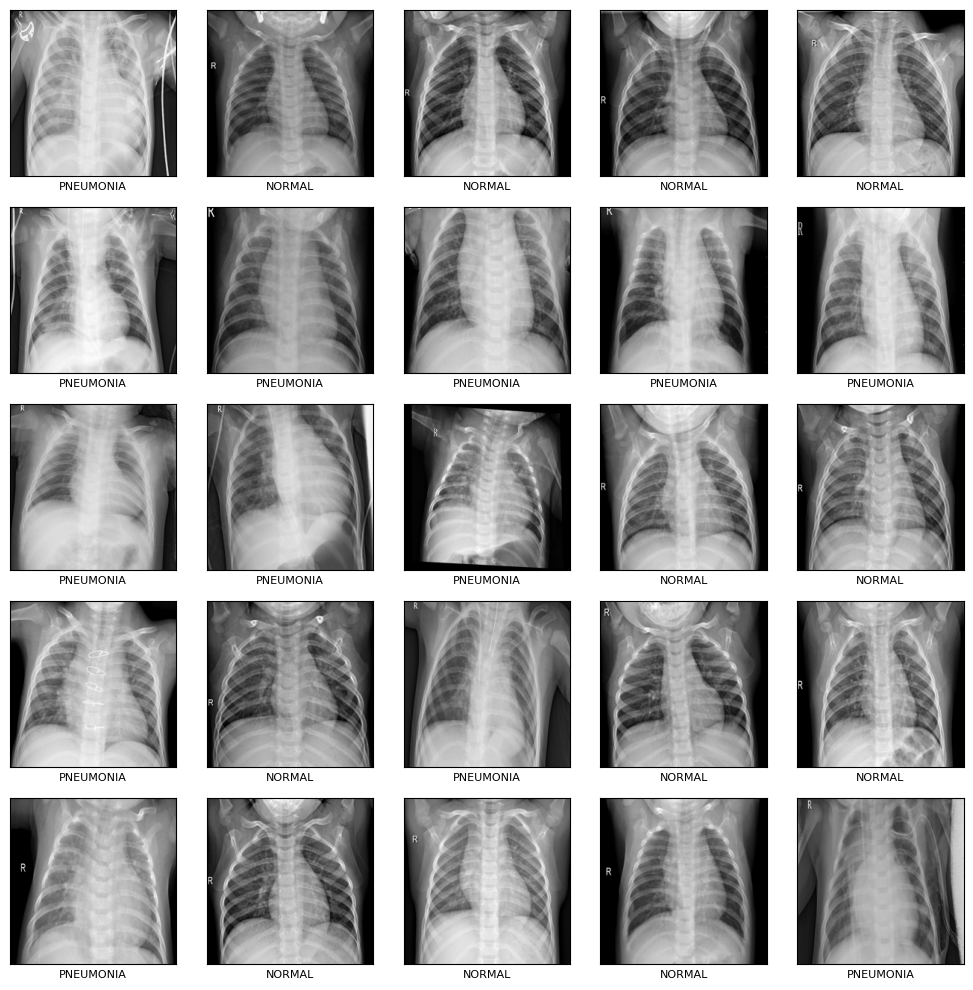

In [109]:
# Visualize a random sample of 25 images from the balanced dataset
sample_25 = random.sample(all_balanced, 25)

plt.figure(figsize=(10,10))
for i, (cls, img_name) in enumerate(sample_25):
    img_path = os.path.join(train_dir, cls, img_name)
    img = Image.open(img_path).resize((224,224))
    
    plt.subplot(5,5,i+1)
    plt.xticks([])   # remove x ticks
    plt.yticks([])   # remove y ticks
    plt.grid(False)  # remove grid
    plt.imshow(img, cmap='gray')
    plt.xlabel(cls, fontsize=8)  # show class label below the image

plt.tight_layout()
plt.show()

In [110]:
# Define image parameters
TARGET_SIZE = (224, 224)  # or (150,150) for small CNN
BATCH_SIZE = 32

In [111]:
#normalize and augment training data
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0,1]
    rotation_range=15,           # Random rotations
    width_shift_range=0.1,       # Horizontal shift
    height_shift_range=0.1,      # Vertical shift
    zoom_range=0.1,              # Zoom in/out
    horizontal_flip=True,        # Flip horizontally
    fill_mode='nearest',         # Fill empty pixels after transforms
    validation_split=0.2         # Optional: split 20% for validation
)


In [112]:
validation_generator = train_datagen.flow_from_directory(
    directory="data/chest_xray/train",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    shuffle=False,
    subset="validation"
)

Found 1043 images belonging to 2 classes.


In [113]:
#create training data generator
train_generator = train_datagen.flow_from_directory(
    directory="data/chest_xray/train",  # path to train folder
    target_size=TARGET_SIZE,
    color_mode="rgb",                    # 3 channels for pretrained models
    batch_size=BATCH_SIZE,
    class_mode="binary",                 # 0/1 labels
    shuffle=True,
    subset="training"                    # only use training part (if using validation split)
)

Found 4173 images belonging to 2 classes.


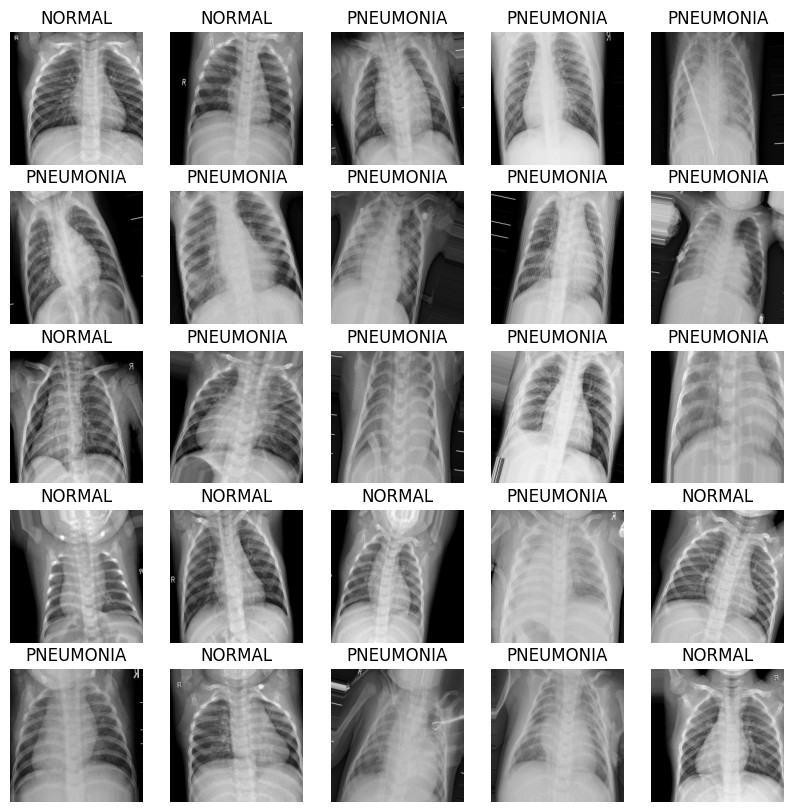

In [114]:
#visualize a batch of training images
x_batch, y_batch = next(train_generator)  # get one batch
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_batch[i])
    plt.title("NORMAL" if y_batch[i]==0 else "PNEUMONIA")
    plt.axis('off')
plt.show()

In [115]:
model = models.Sequential([
    # 1st Convolutional Block
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),

    # 2nd Convolutional Block
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # 3rd Convolutional Block
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),             # Prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Binary output (Normal / Pneumonia)
])

d:\MyProjects\diseasedetection-chestxray\xray\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [116]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [117]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)

d:\MyProjects\diseasedetection-chestxray\xray\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.8037 - loss: 0.4572 - val_accuracy: 0.8543 - val_loss: 0.2923
Epoch 2/10
 99/131 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8786 - loss: 0.2779

In [ ]:
plt.figure(figsize=(10,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [ ]:
# Evaluate model
val_loss, val_acc = model.evaluate(validation_generator)
print(f"✅ Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

In [ ]:
Y_pred = model.predict(validation_generator)
y_pred = np.where(Y_pred > 0.5, 1, 0)

In [ ]:
y_true = validation_generator.classes

# Class labels
class_labels = list(validation_generator.class_indices.keys())

In [ ]:
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Accuracy Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()